## Задача. Построить модель прогнозирования факта сдачи теста

<img src="image/image1.png" alt="Drawing" style="width: 380px;" align="left"/> <br />

### Загружаем библиотеки

In [ ]:
# почему собственно считаем именно конкретные значения балло ....
# нас интересует сам факт сдачи, а не конретные балы

# используем кросс-энтропию
# используем лог-регрессию, если нам именно нужна регрессия

In [1]:
import itertools
import numpy as np
import pandas as pd
import scipy

from sklearn.base import BaseEstimator
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline 

### Загружаем данные

In [2]:
df = pd.read_csv('dataset.csv', sep=';')
print(df.shape)
df.head()

(2133, 12)


,Unnamed: 0,Unnamed: 0.1,school,school_setting,school_type,classroom,teaching_method,n_student,gender,lunch,posttest,target
0,0,0,ANKYI,Urban,Non-public,6OL,Standard,20.0,Male,Does not qualify,72.0,1.0
1,1,1,ANKYI,Urban,Non-public,6OL,Standard,20.0,Male,Does not qualify,79.0,0.0
2,2,2,ANKYI,Urban,Non-public,6OL,Standard,NaN,Male,Does not qualify,76.0,1.0
3,3,3,ANKYI,Urban,Non-public,6OL,Standard,20.0,Male,Does not qualify,77.0,1.0
4,4,4,ANKYI,Urban,Non-public,6OL,Standard,20.0,Male,Does not qualify,76.0,0.0


In [13]:
df["Unnamed: 0.1"].nunique()

2133

In [11]:
len(df)

2133

In [9]:
df["Unnamed: 0"].nunique()

2133

In [3]:
# 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2133 entries, 0 to 2132
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       2133 non-null   int64  
 1   Unnamed: 0.1     2133 non-null   int64  
 2   school           2133 non-null   object 
 3   school_setting   2133 non-null   object 
 4   school_type      2133 non-null   object 
 5   classroom        2133 non-null   object 
 6   teaching_method  2133 non-null   object 
 7   n_student        1991 non-null   float64
 8   gender           2133 non-null   object 
 9   lunch            2133 non-null   object 
 10  posttest         2133 non-null   float64
 11  target           2123 non-null   float64
dtypes: float64(3), int64(2), object(7)
memory usage: 200.1+ KB


In [6]:
import missingno as msno

<AxesSubplot:>

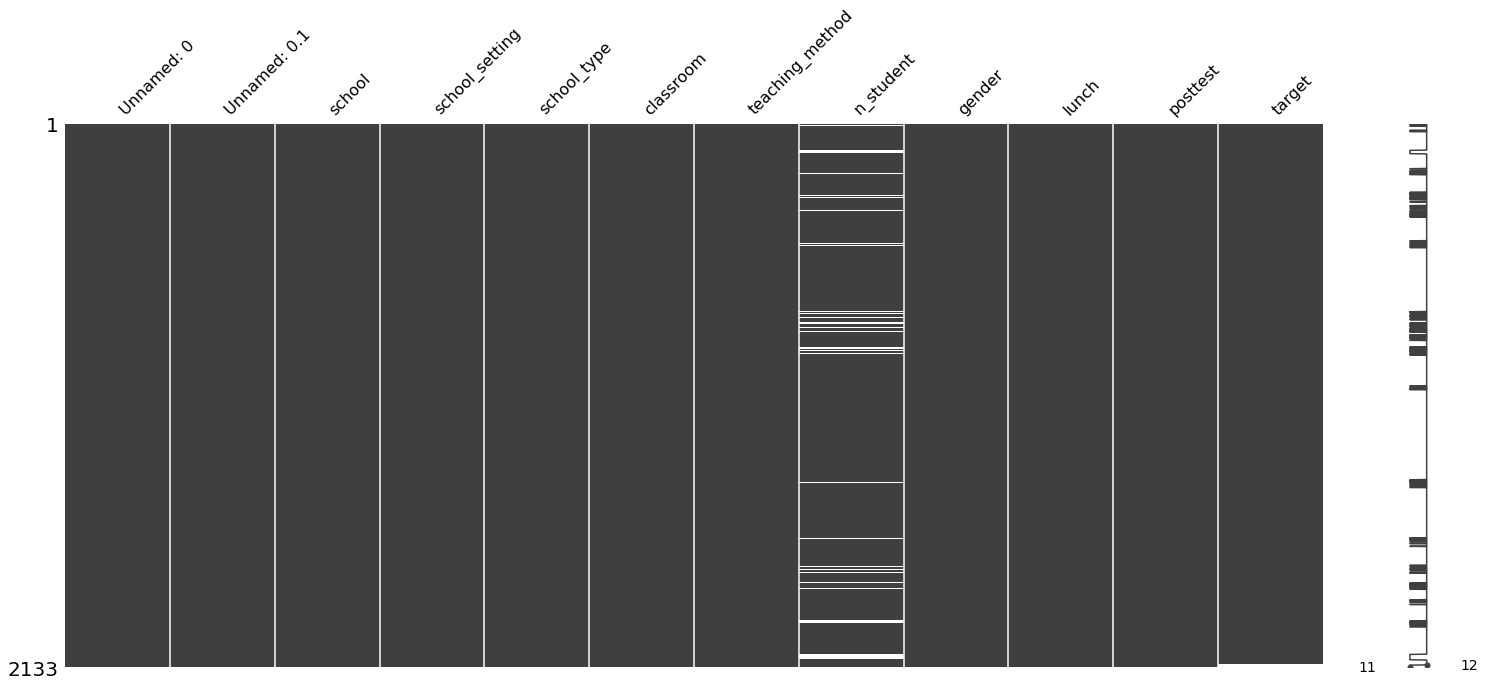

In [7]:
# небольщие пропуски в данных
msno.matrix(df)

### Описание полей
* **school** - Код школы, в которой учится ученик  
* **school_setting** - Тип района в котором находится школа  
* **school_type** - Частная или нет школа  
* **classroom** - внутренний код класса, в котором проиходят занятия  
* **teaching_method** - является ли обучение экспериментальным  
* **n_student** - возраст ученика  
* **gender** - пол ученика  
* **lunch** - Является ли ученик слабозащищенной категорией населения  
* **posttest** - балл по тесту
* **target** - сдал или нет. 1- сдал.

### Разобьем выборку на train / test

In [18]:
import seaborn as sns

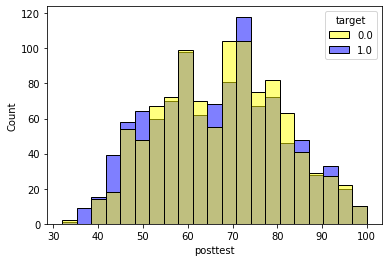

In [39]:
sns.histplot(data=df, x="posttest", hue="target", palette=["yellow", "blue"]);
# хм ... как можно заметить соотношение сдавших и не сдавших не сильно меняется в зависимости от оценки

In [23]:
df["target"].value_counts() # дисбаланса данных нет, но я бы перестраховался и произвёл стратификацию

1.0    1067
0.0    1056
Name: target, dtype: int64

In [41]:
X = df.drop(['posttest'], axis=1)
X = X.drop(['target'], axis=1)
y = df['posttest']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1234)
X_train.shape, X_test.shape

((1599, 10), (534, 10))

In [42]:
# где стратификация по таргету?....

<AxesSubplot:xlabel='posttest', ylabel='Count'>

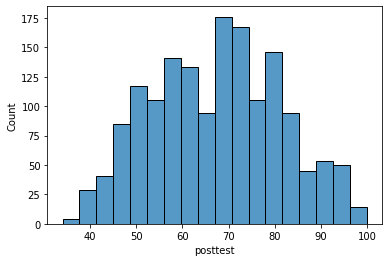

In [45]:
sns.histplot(y_train)

<AxesSubplot:xlabel='posttest', ylabel='Count'>

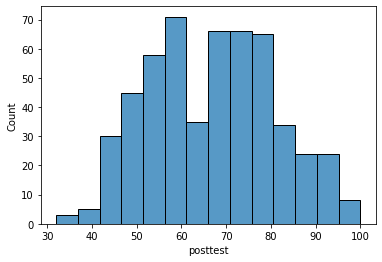

In [46]:
sns.histplot(y_test)
# немного розняться распределения ... я бы всё таки стратификацю сделал бы

### Заменим пропуски в данных

<AxesSubplot:xlabel='n_student', ylabel='Count'>

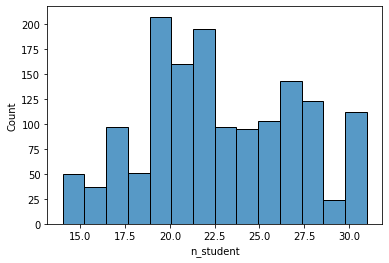

In [50]:
sns.histplot(X_train["n_student"]) # возраст учеников

<AxesSubplot:xlabel='n_student', ylabel='Count'>

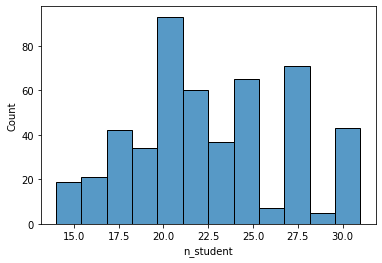

In [53]:
sns.histplot(X_test["n_student"])

In [54]:
X_train = X_train.fillna(X_train.mean())
X_test = X_test.fillna(X_test.mean())

<AxesSubplot:xlabel='n_student', ylabel='Count'>

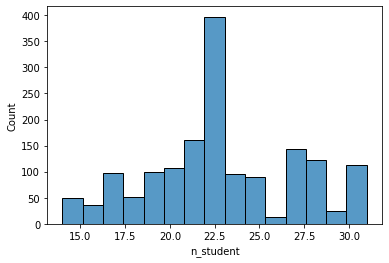

In [55]:
# посмотрим на то, как сильно поменялось распределение после замены пропусков средним значением

sns.histplot(X_train["n_student"])

<AxesSubplot:xlabel='n_student', ylabel='Count'>

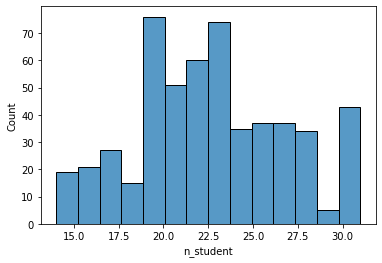

In [56]:
sns.histplot(X_test["n_student"])

In [ ]:
# дабы не портить инзачальное распределение ... ы бы засемплил данные из полученных распределений

-----------

В качестве целевой переменной  будем рассматривать балл по тесту.  <br />
Построим линейную регрессию.

### Заинжинирим новую переменную
пол*возраст
для каждой комбинации посчитаем weight of evidence и будем его использовать в модели

In [57]:
df.gender.unique()

array(['Male', 'Female'], dtype=object)

In [58]:
df.n_student.unique()

array([20., nan, 21., 18., 15., 16., 19., 17., 28., 27., 24., 14., 22.,
       23., 31., 25., 26., 29., 30.])

In [59]:
for i in df.gender.unique():
    for j in df.n_student.unique():
        l=df.loc[(df.gender==i) & (df.n_student>=j)]
        woe=l.target.sum()/(l.target.count()-df.target.mean()-1)
        df.loc[(df.gender==i) & (df.n_student>=j), 'woe_agegender']=woe

<AxesSubplot:xlabel='woe_agegender', ylabel='Count'>

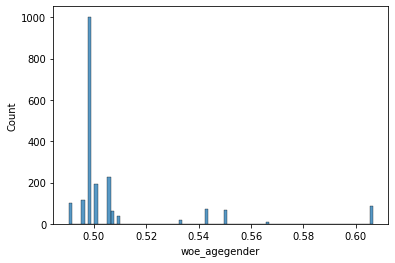

In [61]:
sns.histplot(data=df, x="woe_agegender") # непонятно, а для чего собственно нужен этот признак .... почему такой дисбаланс явный..

In [62]:
X

,Unnamed: 0,Unnamed: 0.1,school,school_setting,school_type,classroom,teaching_method,n_student,gender,lunch
0,0,0,ANKYI,Urban,Non-public,6OL,Standard,20.0,Male,Does not qualify
1,1,1,ANKYI,Urban,Non-public,6OL,Standard,20.0,Male,Does not qualify
2,2,2,ANKYI,Urban,Non-public,6OL,Standard,NaN,Male,Does not qualify
3,3,3,ANKYI,Urban,Non-public,6OL,Standard,20.0,Male,Does not qualify
4,4,4,ANKYI,Urban,Non-public,6OL,Standard,20.0,Male,Does not qualify
...,...,...,...,...,...,...,...,...,...,...
2128,2128,2128,ZOWMK,Urban,Public,ZBH,Standard,30.0,Female,Does not qualify
2129,2129,2129,ZOWMK,Urban,Public,ZBH,Standard,30.0,Female,Qualifies for reduced/free lunch
2130,2130,2130,ZOWMK,Urban,Public,ZBH,Standard,30.0,Female,Qualifies for reduced/free lunch
2131,2131,2131,ZOWMK,Urban,Public,ZBH,Standard,30.0,Male,Qualifies for reduced/free lunch


### Дальше накинем one-hot encoding

In [ ]:
# Почему LabelEncder ... для его использования, нужно убедиться, что
# данные действиттельно порядковые и мало того, нужно отдавать себя отчёт,
# как моделировать этот порядок

In [70]:
class LinearRegressionEncoder(BaseEstimator):
    def __init__(self):
        self.linreg = LinearRegression()
        self.encoders = {}
    
    
    def fit(self, X, y):
        X_enc = X.copy()
        categorical_features = X.columns[X.dtypes == 'object']
        
        for col in categorical_features:
            le = LabelEncoder()
            X_enc[col] = le.fit_transform(X[col])
            self.encoders[col] = le
            
        self.linreg.fit(X_enc, y)

        # считаем значимость
        y_pred = self.linreg.predict(X_enc)
        sse = np.sum((y_pred - y) ** 2, axis=0) / float(X_enc.shape[0] - X_enc.shape[1])
        se = np.array([np.sqrt(np.diagonal(sse * np.linalg.pinv(np.dot(X_enc.T, X_enc))))])

        self.t = self.linreg.coef_ / se
        self.p = 2 * (1 - scipy.stats.t.cdf(np.abs(self.t), y.shape[0] - X_enc.shape[1]))
        
        return self
    
    def predict(self, X):
        X_enc = X.copy()
        categorical_features = X.columns[X.dtypes == 'object']
        
        for col in categorical_features:
            X_enc[col] = self.encoders[col].transform(X[col])
            
        y_pred = self.linreg.predict(X_enc)
        
        return y_pred
    
    def score(self, X, y):        
        
        y_pred = self.predict(X)
        return mean_absolute_error(y, y_pred)

In [71]:
df.target.unique()

array([ 1.,  0., nan])

In [72]:
%%time
linreg = LinearRegressionEncoder()
linreg.fit(X_train, y_train)

Wall time: 22 ms


LinearRegressionEncoder()

In [73]:
print('TRAIN MSE:', linreg.score(X_train, y_train))
print('TEST MSE:', linreg.score(X_test, y_test))

TRAIN MSE: 7.4971977724881365
TEST MSE: 7.661175811821432


### Ошибка на тесте не сильно больше чем на трейне. Значит модель отличная

Улучшим модель, исключив из данных незначимые факторы

In [74]:
## здесь дописать
for p_val, factor in itertools.zip_longest(np.array(linreg.p[0]), np.array(X.columns)):
    print(factor, ' - ', round(p_val, 6))

Unnamed: 0  -  1.4e-05
Unnamed: 0.1  -  1.4e-05
school  -  8e-06
school_setting  -  0.005098
school_type  -  1e-06
classroom  -  0.593291
teaching_method  -  0.0
n_student  -  0.0
gender  -  0.044671
lunch  -  0.0


удалим факторы у которых pvalue = 0 и перевзвесим коэффициенты

In [76]:
sign = [f for p, f in itertools.zip_longest(np.array(linreg.p[0]), np.array(X.columns)) if p == 0]
sign

['teaching_method', 'n_student', 'lunch']

In [77]:
%%time
linreg2 = LinearRegressionEncoder()
linreg2.fit(X_train.drop(sign, axis=1), y_train)

Wall time: 13 ms


LinearRegressionEncoder()

In [78]:
print('TRAIN MSE after drop insignificant:', 
      linreg2.score(X_train.drop(sign, axis=1), y_train))
print('TEST MSE after drop insignificant', 
      linreg2.score(X_test.drop(sign, axis=1), y_test))

TRAIN MSE after drop insignificant: 9.948255552267824
TEST MSE after drop insignificant 9.809958121750814


### После удаления получили модель чуть похуже, но в ней оценки коэффициентов несмещены